This script contains timeseries diagrams that show how the data changes over all of the sample years for multiple depths.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
from collections import OrderedDict
import Keegan_eval_tools as ket

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=range(2007,2020)
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Years: '''+ str(years)))

## Years: range(2007, 2020)

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [14]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
dictBot=dict()
dictCTD=dict()
dictBot_Chl=dict()

for Y in years:
    with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictBot[Y]=pickle.load(hh)
        
for Y in years:
    with open(os.path.join(saveloc,f'data_CTD_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictCTD[Y]=pickle.load(hh)
    
for Y in years:
    with open(os.path.join(saveloc,f'data_Pheo_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictBot_Chl[Y]=pickle.load(hh)
        
data=pd.concat(dictBot.values(), ignore_index=True)
data_CTD=pd.concat(dictCTD.values(), ignore_index=True)
data_Pheo=pd.concat(dictBot_Chl.values(), ignore_index=True)

In [15]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

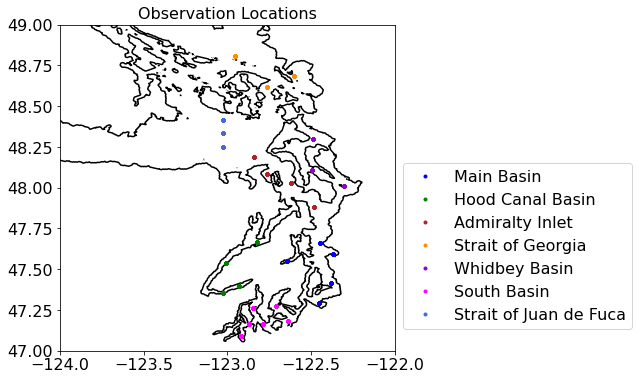

In [16]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)

# When working with multiple years, a for loop is necessary to split things up by months. 
JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

In [25]:
#creating new dictionaries that make it easy to call on specific years.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
datyearreg=dict()
for iyear in datyear:
    datyearreg[iyear]=dict()
    for iregion in datyear[iyear].Basin.unique():
        datyearreg[iyear][iregion]=datyear[iyear].loc[datyear[iyear].Basin==iregion]
        
#Adding extra columns to assist in analysis.
data_Pheo['log_Chl']=ket.logt(data_Pheo['Chla_Lab'])
data_Pheo['log_mod_diatoms']=ket.logt(data_Pheo['mod_diatoms']*1.8)
data_Pheo['log_mod_ciliates']=ket.logt(data_Pheo['mod_ciliates']*1.8)
data_Pheo['log_mod_flagellates']=ket.logt(data_Pheo['mod_flagellates']*1.8)
data_Pheo['mod_Chl']=((data_Pheo['mod_diatoms']*1.8)+(data_Pheo['mod_ciliates']*1.8)+(data_Pheo['mod_flagellates']*1.8))
data_Pheo['log_mod_Chl']=ket.logt((data_Pheo['mod_diatoms']*1.8)+(data_Pheo['mod_ciliates']*1.8)+(data_Pheo['mod_flagellates']*1.8))

# All years condensed timeseries.

In [10]:
def all_years(data,obsvar,modvar,title):
    start_date=dt.datetime(2007,1,1)
    end_date=dt.datetime(2019,12,31)
    fig,ax=plt.subplots(1,1,figsize=(19,8))
    ps=tsertser_graph(ax,data,obsvar,modvar,start_date,end_date)
    ax.legend(handles=ps)
    ax.set_ylabel(f'{obsvar} ($\mu$M)')
    ax.set_xlabel('Date')
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    M = 15
    xticks = mpl.ticker.MaxNLocator(M)
    ax.xaxis.set_major_locator(xticks)

## Nitrate

<AxesSubplot:title={'center':'Timeseries of modeled and observed NO23 for depth greater than 22 metres'}, xlabel='Date', ylabel='NO23 ($\\mu$M)'>

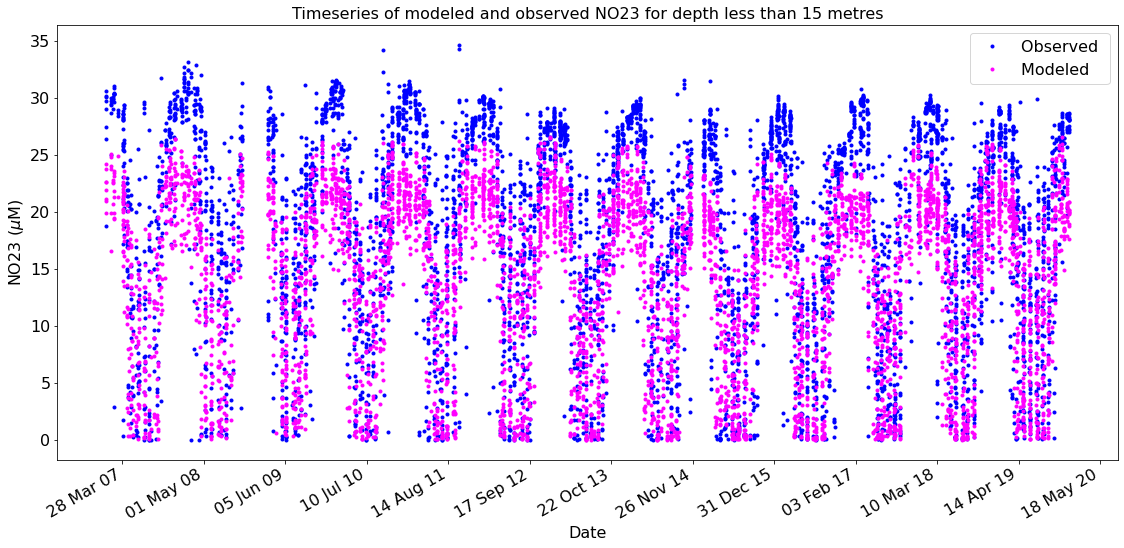

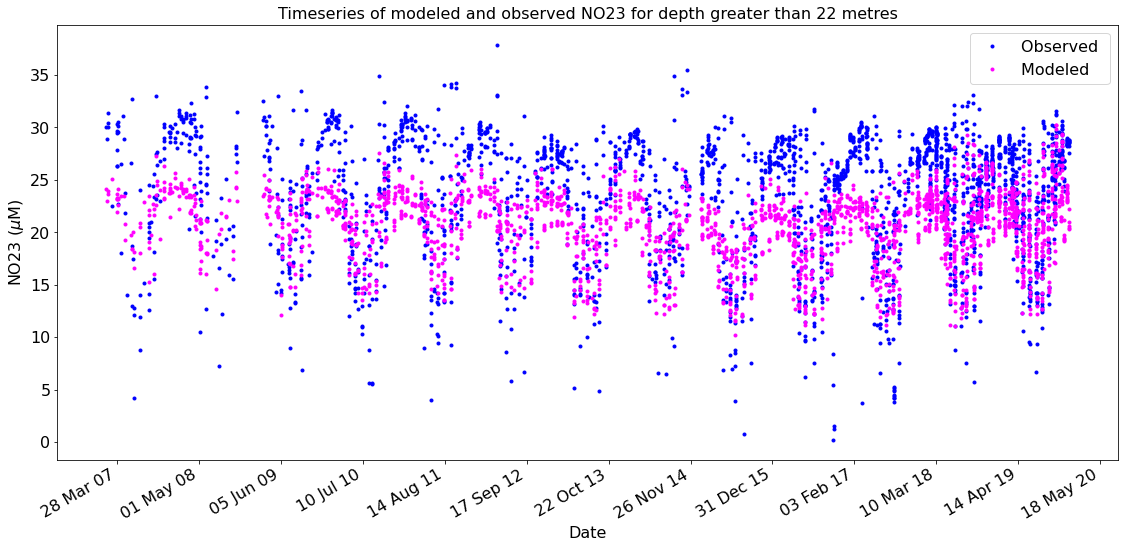

In [11]:
obsvar='NO23'
modvar='mod_nitrate'
title=('Timeseries of modeled and observed NO23 for depth less than 15 metres')
ket.all_years(data[data.Z <15],obsvar,modvar,title)
title=('Timeseries of modeled and observed NO23 for depth greater than 22 metres')
ket.all_years(data[data.Z > 22],obsvar,modvar,title)

## Silicon

<AxesSubplot:title={'center':'Timeseries of modeled and observed Si for depth greater than 22 metres'}, xlabel='Date', ylabel='Si ($\\mu$M)'>

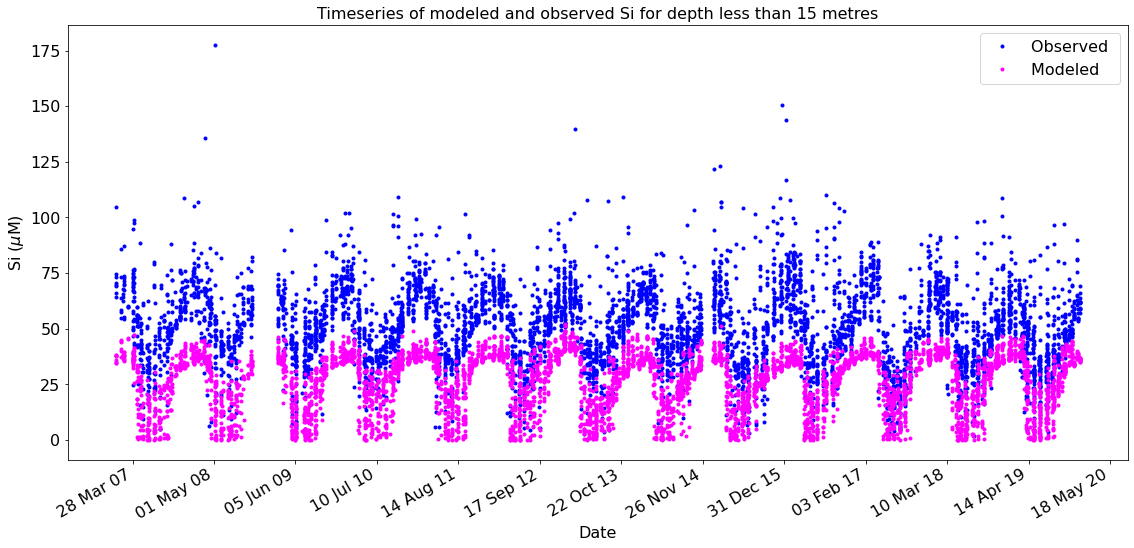

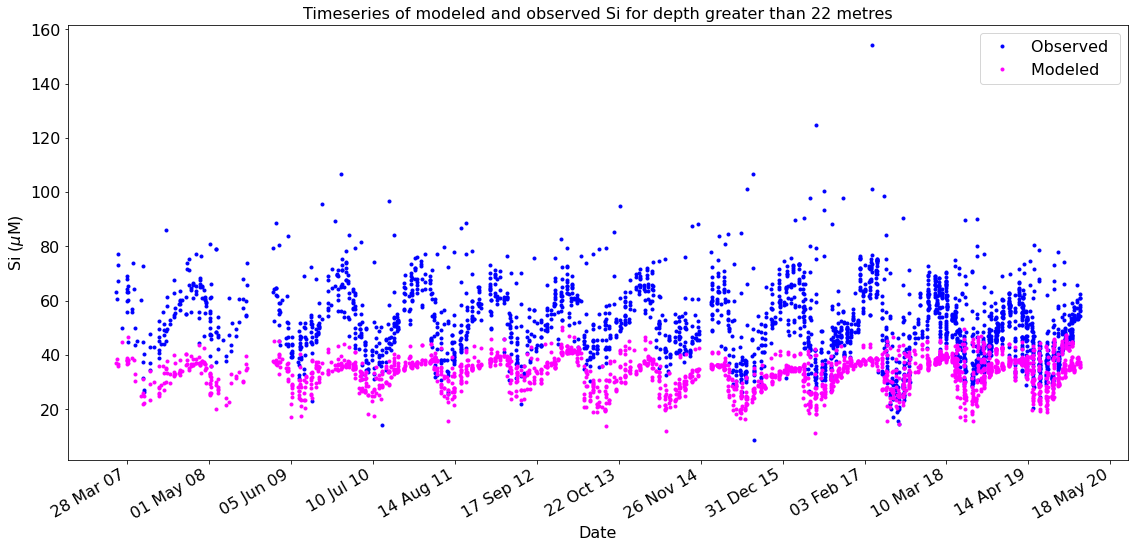

In [12]:
obsvar='Si'
modvar='mod_silicon'
title=('Timeseries of modeled and observed Si for depth less than 15 metres')
ket.all_years(data[data.Z <15],obsvar,modvar,title)
title=('Timeseries of modeled and observed Si for depth greater than 22 metres')
ket.all_years(data[data.Z > 22],obsvar,modvar,title)

## Ammonium

(0.0, 8.0)

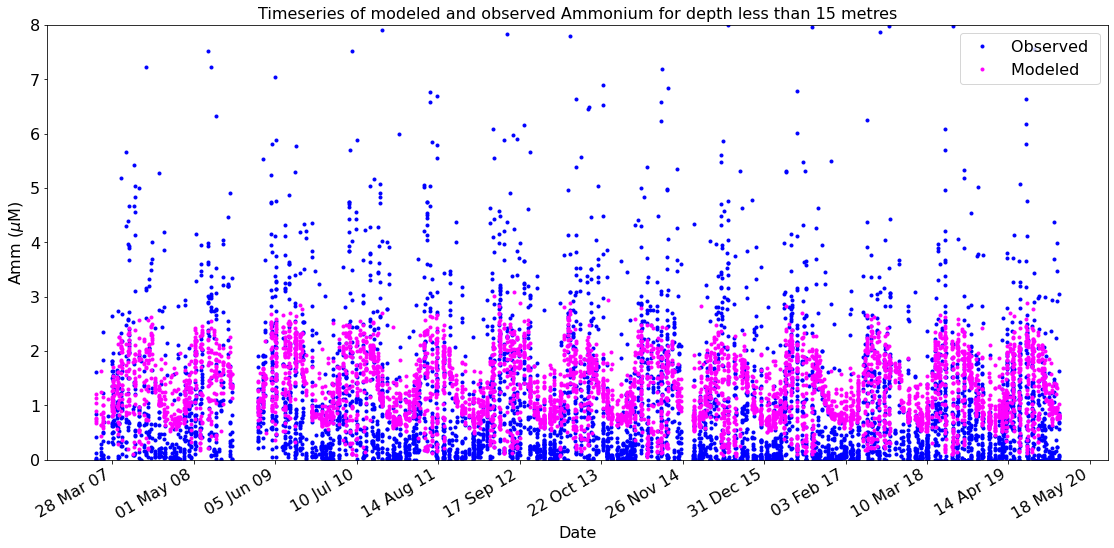

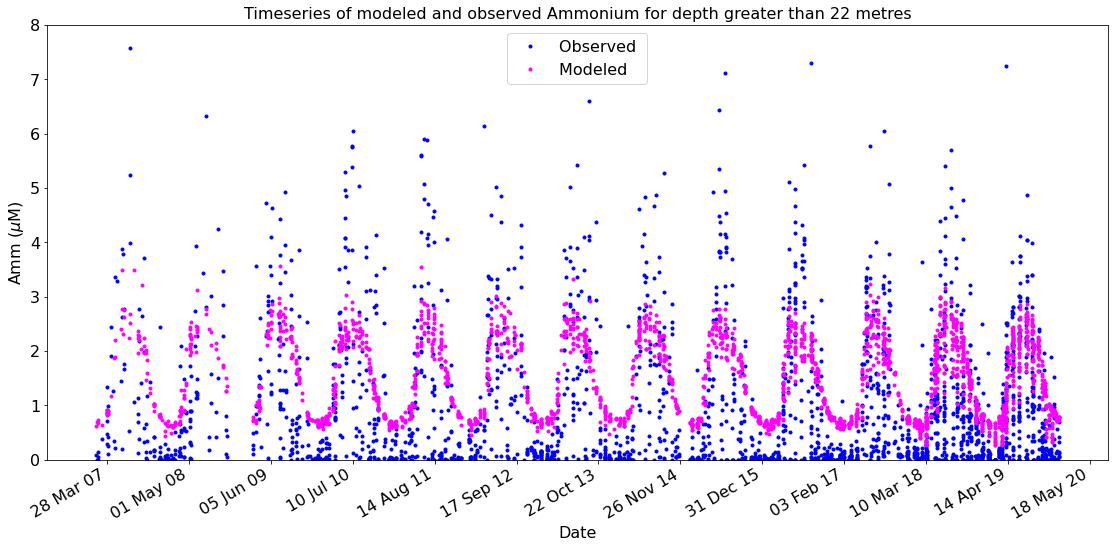

In [13]:
obsvar='Amm'
modvar='mod_ammonium'
title=('Timeseries of modeled and observed Ammonium for depth less than 15 metres')
ket.all_years(data[data.Z <15],obsvar,modvar,title)
plt.ylim(0,8)
title=('Timeseries of modeled and observed Ammonium for depth greater than 22 metres')
ket.all_years(data[data.Z > 22],obsvar,modvar,title)
plt.ylim(0,8)

<AxesSubplot:title={'center':'Timeseries of modeled and observed Salinity for depth greater than 22 metres'}, xlabel='Date', ylabel='SA (g/kg)'>

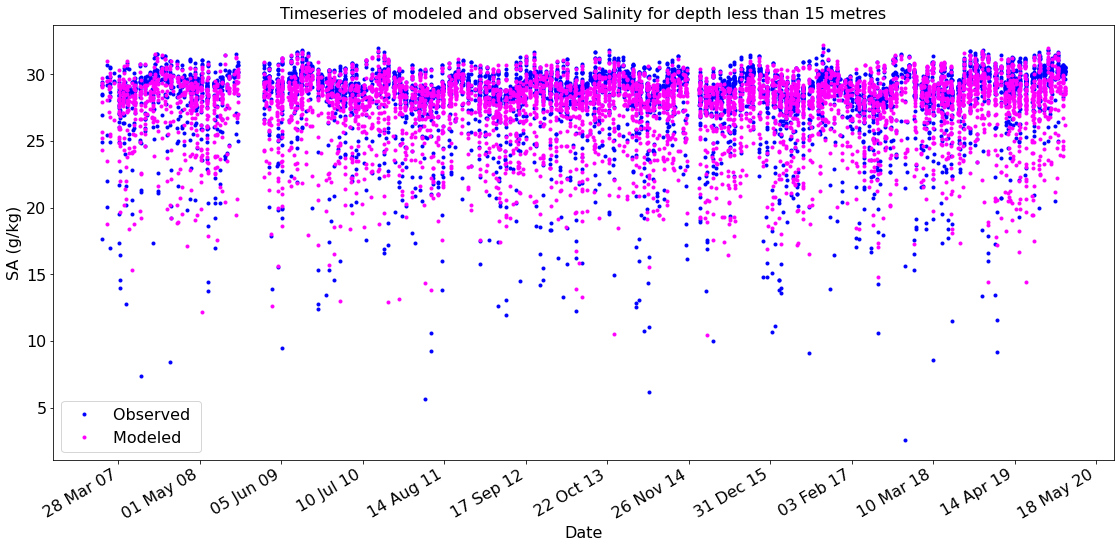

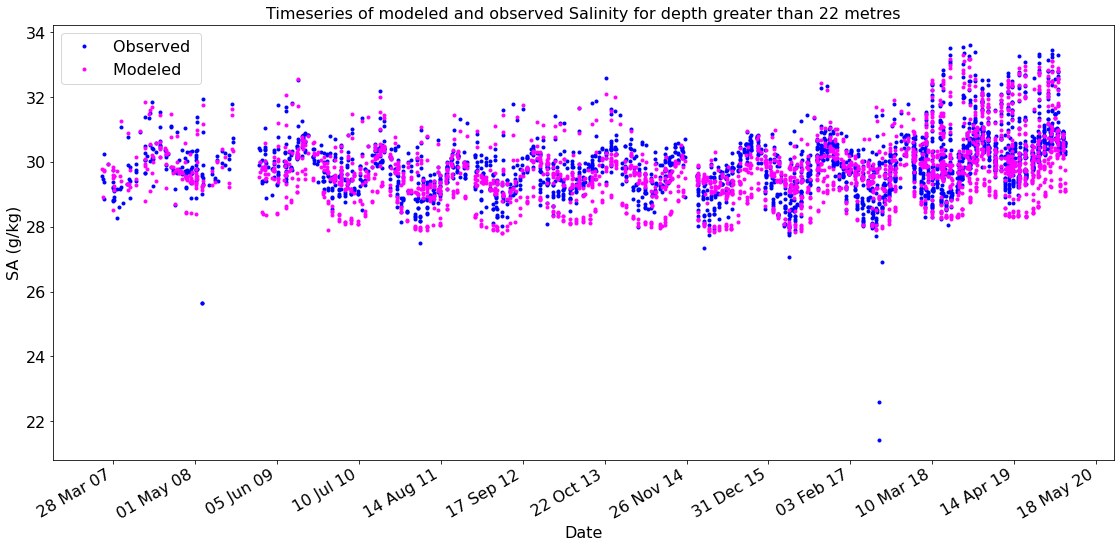

In [30]:
obsvar='SA'
modvar='mod_vosaline'
title=('Timeseries of modeled and observed Salinity for depth less than 15 metres')
ket.all_years(data[data.Z <15],obsvar,modvar,title,units='(g/kg)')
title=('Timeseries of modeled and observed Salinity for depth greater than 22 metres')
ket.all_years(data[data.Z > 22],obsvar,modvar,title,units='(g/kg)')

<AxesSubplot:title={'center':'Timeseries of modeled and observed Temperature for depth greater than 22 metres'}, xlabel='Date', ylabel='CT ($\\mu$M)'>

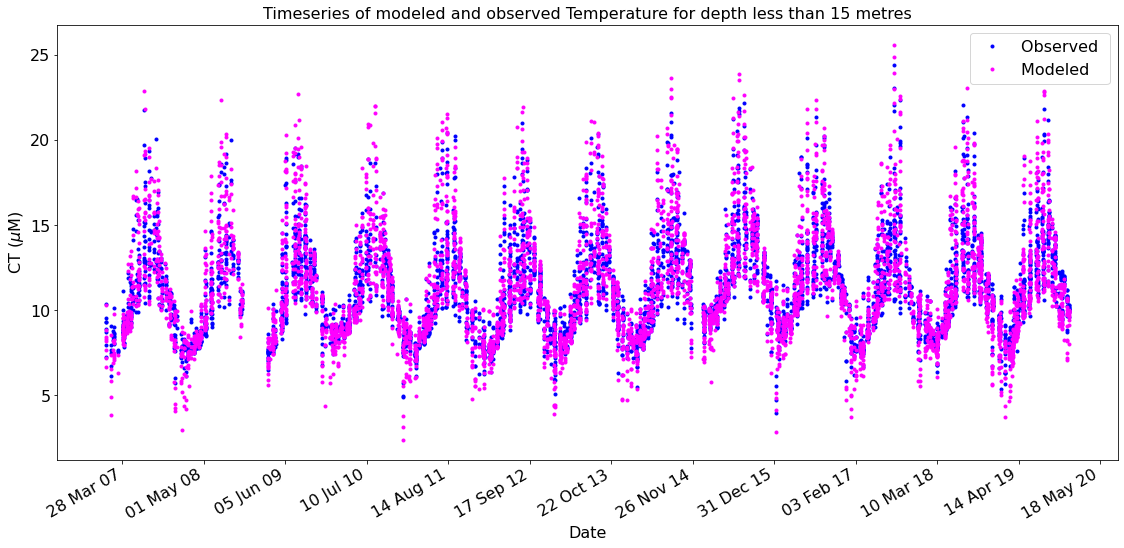

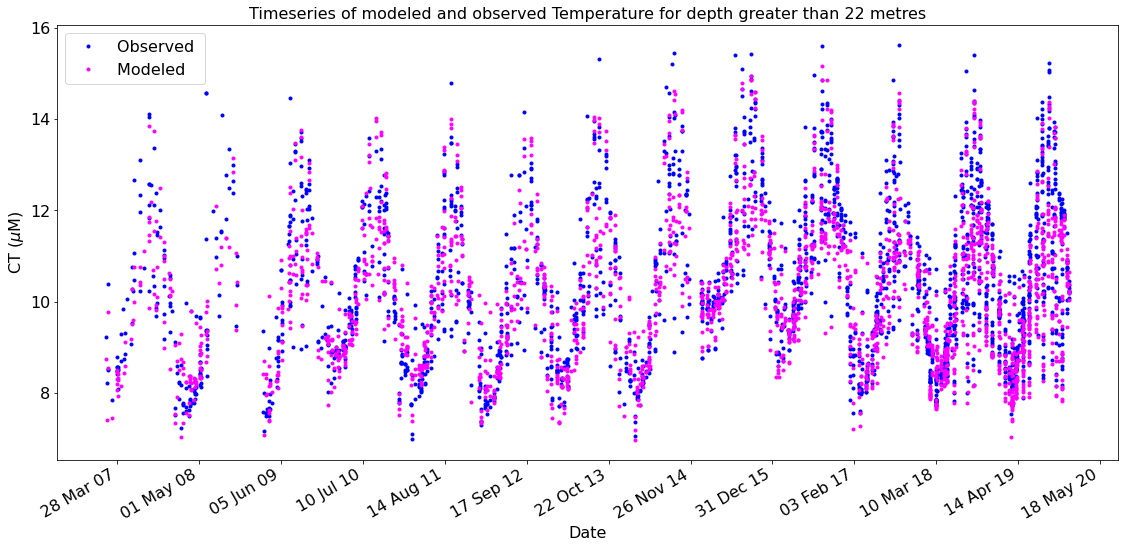

In [21]:
obsvar='CT'
modvar='mod_votemper'
title=('Timeseries of modeled and observed Temperature for depth less than 15 metres')
ket.all_years(data[data.Z <15],obsvar,modvar,title,units='(C$^o$)')
title=('Timeseries of modeled and observed Temperature for depth greater than 22 metres')
ket.all_years(data[data.Z > 22],obsvar,modvar,title,units='(C$^o$)')

(0.0, 10.0)

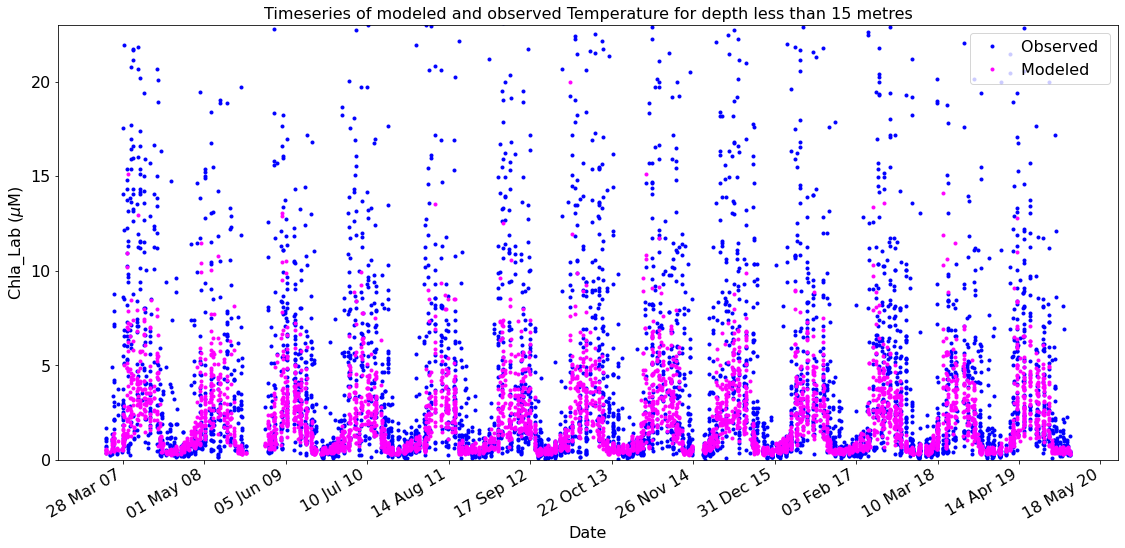

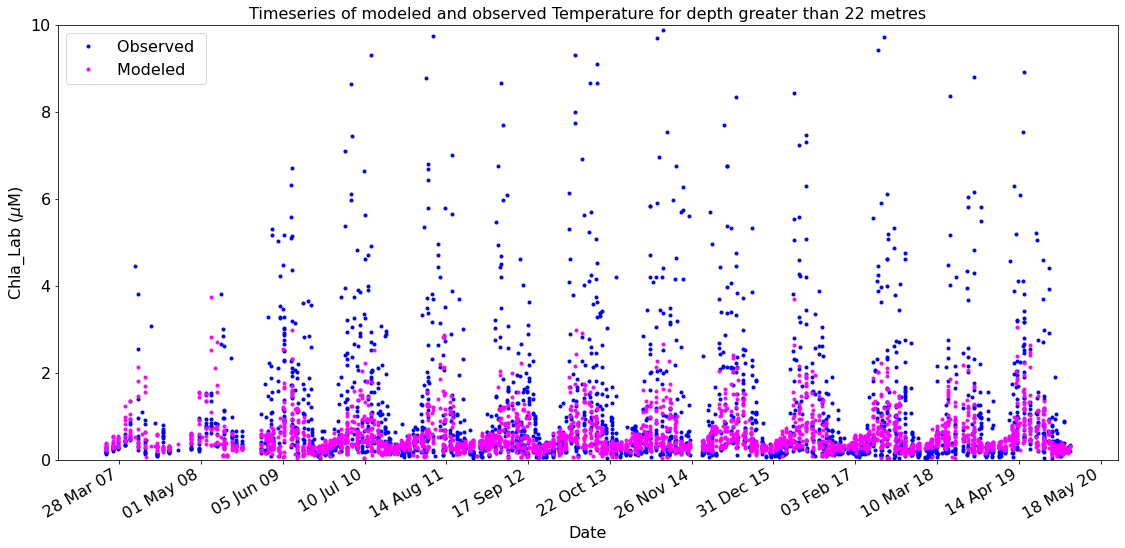

In [29]:
obsvar='Chla_Lab'
modvar='mod_Chl'
title=('Timeseries of modeled and observed Chlorophyll for depth less than 15 metres')
ket.all_years(data_Pheo[data_Pheo.Z <15],obsvar,modvar,title)
plt.ylim(0,23)
title=('Timeseries of modeled and observed Chlorophyll for depth greater than 22 metres')
ket.all_years(data_Pheo[data_Pheo.Z > 22],obsvar,modvar,title)
plt.ylim(0,10)